## Import the packages / functions

In [2]:
import matplotlib as mpl
# mpl.use("pgf")
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time

import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
from tqdm.notebook import trange
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from functools import partial

import torch
import vjf
from vjf import online

from tqdm.notebook import trange

## Import the dataset

The data loading below is the lorenz attractor with (100 trajectories, 200dim, 500 to 2500 time points, with noise sd=0.05)

In [3]:
data = np.load('lorenz_100trajectories_200dim_500to2500_noise0.05.npz')

In [4]:
xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

## Derivation 
ref: http://www.cs.columbia.edu/~liulp/pdf/linear_normal_dist.pdf

$ p(y_t \vert y_{\leq{t-1}}) = \iint p(y_t \vert x_t) p(x_t \vert x_{t-1}) p(x_{t-1} \vert y_{\leq{t-1}}) dx_{t-1} dx_t $


* $ p(x_{t-1} \vert y_{\leq{t-1}}) \longrightarrow \text{filtering}\longrightarrow N(\mu_f, \Sigma_f) \in \mathbb{R}^dx $ 


* $ p(x_t \vert x_{t-1}) \longrightarrow \text{transition} \longrightarrow N(W_s x_{t-1}, \Sigma_s) \in \mathbb{R}^dx $


* $ p(x_t \vert y_{\leq{t-1}}) = p(x_t \vert x_{t-1}) p(x_{t-1} \vert y_{\leq{t-1}}) \sim N(W_s \mu_f, W_s \Sigma_f W^T_s + \Sigma_s)$


* $ p(y_t \vert x_t) \longrightarrow \text{decoder} \longrightarrow N(W_d x_t + b_d, \Sigma_d)$


* $ p(y_t \vert y_{\leq{t-1}}) = N(W_d W_s \mu_f + b_d, W_d (W_s \Sigma_f W_s^T + \Sigma_s) W_d^T + \Sigma_d)$

## Fit the model & save the log probability 
(Important to Note that the dynamics is now 'linear' not 'RBF')

In [5]:
likelihood = 'gaussian'  # Gaussian observation
dynamics = 'linear'  # RBF network dynamic model
recognizer = "mlp"  # MLP recognitiom model
rdim = 50  # number of RBFs
hdim = 100  # number of MLP hidden units

mdl = online.VJF(
    config=dict(
        resume=False,
        xdim=xdim,
        ydim=ydim,
        udim=udim,
        Ydim=udim,
        Udim=udim,
        rdim=rdim,
        hdim=hdim,
        lr=1e-3,
        clip_gradients=5.0,
        debug=True,
        likelihood=likelihood,  # 
        system=dynamics,
        recognizer=recognizer,
        C=(None, True),  # loading matrix: (initial, estimate)
        b=(None, True),  # bias: (initial, estimate)
        A=(None, False),  # transition matrix if LDS
        B=(np.zeros((xdim, udim)), False),  # interaction matrix
        Q=(1.0, True),  # state noise
        R=(1.0, True),  # observation noise
    )
)    

{'A': (None, False),
 'B': (array([[0.],
       [0.],
       [0.]]), False),
 'C': (None, True),
 'Q': (1.0, True),
 'R': (1.0, True),
 'Udim': 1,
 'Ydim': 1,
 'activation': 'tanh',
 'b': (None, True),
 'batch_norm': False,
 'clip_gradients': 5.0,
 'debug': True,
 'hdim': 100,
 'likelihood': 'gaussian',
 'lr': 0.001,
 'optimizer': 'adam',
 'path': '/home/nayoungjun/workspace/vjf/notebook',
 'random_seed': None,
 'rdim': 50,
 'recognizer': 'mlp',
 'resume': False,
 'system': 'linear',
 'udim': 1,
 'xdim': 3,
 'ydim': 200}
Gaussian likelihood


In [6]:
EXAMPLE = 0
yy = torch.from_numpy(ys[EXAMPLE]).float()
uu = torch.from_numpy(us[EXAMPLE]).float()

q = None

logprobs = []
distances = []

Note that we are using only the first trajectory to compute the log probability.

We can combine all of the trajectories to make the training better & noise lower.

In [7]:
for t in trange(yy.shape[0]): # we are only using the trajectory number 0.
    y = yy[t].unsqueeze(0)
    u = uu[t].unsqueeze(0)
    q, loss = mdl.feed((y, u), q)
    
    filtering_mu, filtering_logvar = q
    
    mu_f = filtering_mu.detach().numpy().T
    var_f = filtering_logvar.detach().exp().numpy().T
    Sigma_f = np.eye(xdim) * var_f
    
    W_s = (torch.eye(xdim) + mdl.system.transition.weight.detach()).numpy()
    var_s = mdl.state_noise.logvar.detach().exp().numpy().T
    Sigma_s = np.eye(xdim) * var_s
    
    W_d = mdl.decoder.linear.weight.detach().numpy()
    bias_d = mdl.decoder.linear.bias.detach().numpy()[:, None]
    var_d = mdl.likelihood.logvar.detach().exp().numpy().T
    Sigma_d = np.eye(ydim) * var_d
    
    mu = (W_d @ W_s @ mu_f + bias_d).flatten()
    Sigma = W_d @ (W_s @ Sigma_f @ W_s.T + Sigma_s) @ W_d.T + Sigma_d
    
    logprob = multivariate_normal(mu, Sigma).logpdf(y)
    distance = np.linalg.norm(mu - y.numpy())
    
    logprobs.append(logprob)
    distances.append(distance)

## Plotting the log probability 

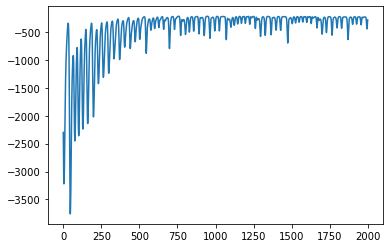

In [8]:
plt.plot(logprobs)

## Plotting the L2 distance

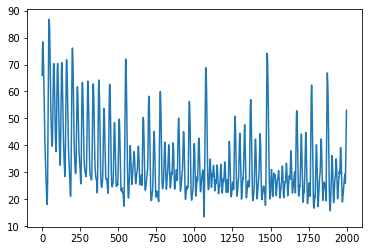

In [9]:
plt.plot(distances)

## Let's do this one more time with another dataset containing chaotic first 500 steps.

In [14]:
data = np.load('lorenz_100trajectories_200dim_0to2000_noise0.05.npz')

In [15]:
xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

In [16]:
likelihood = 'gaussian'  # Gaussian observation
dynamics = 'linear'  # RBF network dynamic model
recognizer = "mlp"  # MLP recognitiom model
rdim = 50  # number of RBFs
hdim = 100  # number of MLP hidden units

mdl = online.VJF(
    config=dict(
        resume=False,
        xdim=xdim,
        ydim=ydim,
        udim=udim,
        Ydim=udim,
        Udim=udim,
        rdim=rdim,
        hdim=hdim,
        lr=1e-3,
        clip_gradients=5.0,
        debug=True,
        likelihood=likelihood,  # 
        system=dynamics,
        recognizer=recognizer,
        C=(None, True),  # loading matrix: (initial, estimate)
        b=(None, True),  # bias: (initial, estimate)
        A=(None, False),  # transition matrix if LDS
        B=(np.zeros((xdim, udim)), False),  # interaction matrix
        Q=(1.0, True),  # state noise
        R=(1.0, True),  # observation noise
    )
)    

{'A': (None, False),
 'B': (array([[0.],
       [0.],
       [0.]]), False),
 'C': (None, True),
 'Q': (1.0, True),
 'R': (1.0, True),
 'Udim': 1,
 'Ydim': 1,
 'activation': 'tanh',
 'b': (None, True),
 'batch_norm': False,
 'clip_gradients': 5.0,
 'debug': True,
 'hdim': 100,
 'likelihood': 'gaussian',
 'lr': 0.001,
 'optimizer': 'adam',
 'path': '/home/nayoungjun/workspace/vjf/notebook',
 'random_seed': None,
 'rdim': 50,
 'recognizer': 'mlp',
 'resume': False,
 'system': 'linear',
 'udim': 1,
 'xdim': 3,
 'ydim': 200}
Gaussian likelihood


In [17]:
EXAMPLE = 0
yy = torch.from_numpy(ys[EXAMPLE]).float()
uu = torch.from_numpy(us[EXAMPLE]).float()

q = None

logprobs = []
distances = []

In [18]:
for t in trange(yy.shape[0]): # we are only using the trajectory number 0.
    y = yy[t].unsqueeze(0)
    u = uu[t].unsqueeze(0)
    q, loss = mdl.feed((y, u), q)
    
    filtering_mu, filtering_logvar = q
    
    mu_f = filtering_mu.detach().numpy().T
    var_f = filtering_logvar.detach().exp().numpy().T
    Sigma_f = np.eye(xdim) * var_f
    
    W_s = (torch.eye(xdim) + mdl.system.transition.weight.detach()).numpy()
    var_s = mdl.state_noise.logvar.detach().exp().numpy().T
    Sigma_s = np.eye(xdim) * var_s
    
    W_d = mdl.decoder.linear.weight.detach().numpy()
    bias_d = mdl.decoder.linear.bias.detach().numpy()[:, None]
    var_d = mdl.likelihood.logvar.detach().exp().numpy().T
    Sigma_d = np.eye(ydim) * var_d
    
    mu = (W_d @ W_s @ mu_f + bias_d).flatten()
    Sigma = W_d @ (W_s @ Sigma_f @ W_s.T + Sigma_s) @ W_d.T + Sigma_d
    
    logprob = multivariate_normal(mu, Sigma).logpdf(y)
    distance = np.linalg.norm(mu - y.numpy())
    
    logprobs.append(logprob)
    distances.append(distance)

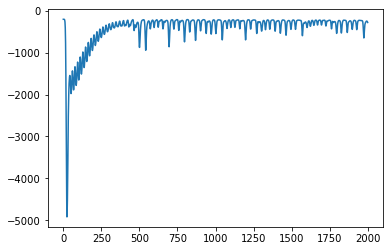

In [19]:
plt.plot(logprobs)

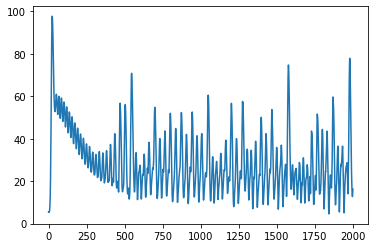

In [20]:
plt.plot(distances)

## We can indeed see that the model struggles for the first 500 steps!